In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes

sns.set()

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor,AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from imutils import paths

In [4]:
# construct the arg parser
epochs = 25
data_path = r"/content/drive/MyDrive/ImageDatasets/flowers17/images"

args = {
    "dataset": data_path,
    "model": r""
}

# construct the image generator
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [5]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(args["dataset"]))
class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
unique_class_names = np.unique(class_names)

[INFO] loading images......


In [6]:
# init the preprocessprs
aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths, verbose=200)
data = data.astype(np.float32) / 255.0

[INFO] processed 200/1360
[INFO] processed 400/1360
[INFO] processed 600/1360
[INFO] processed 800/1360
[INFO] processed 1000/1360
[INFO] processed 1200/1360


In [7]:
# split the data
trainx, testx, trainy, testy = train_test_split(data, labels,
                                                random_state=42,
                                                test_size=0.25)
# encode the labesl
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)

In [8]:
# load the base net
base_model = VGG16(weights="imagenet", include_top=False,
                   input_tensor=Input(shape=(224, 224, 3)))  # type: Model
head_model = FCHeadNet.builld(baseModel=base_model,
                              classes=len(unique_class_names),
                              fc_nodes=[256])  # type: Model

model = Model(inputs=base_model.input, outputs=head_model)

58892288/58889256 [==============================] - 0s 0us/step
BaseModel Out Shape:  (None, 7, 7, 512)


In [9]:
# freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# compile the model
print(f"[INFO] compiling the model......")
opt = RMSprop(lr=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling the model......


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
print(f"[INFO] training head for few epochs......")
model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                    validation_data=(testx, testy),
                    epochs=epochs,
                    verbose=1)

[INFO] training head for few epochs......


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
32/32 [==============================] - 56s 648ms/step - loss: 4.9458 - accuracy: 0.1824 - val_loss: 2.1831 - val_accuracy: 0.2500
Epoch 2/25
32/32 [==============================] - 11s 349ms/step - loss: 2.2730 - accuracy: 0.2637 - val_loss: 1.4980 - val_accuracy: 0.5765
Epoch 3/25
32/32 [==============================] - 11s 353ms/step - loss: 1.9409 - accuracy: 0.3745 - val_loss: 1.1577 - val_accuracy: 0.6559
Epoch 4/25
32/32 [==============================] - 11s 354ms/step - loss: 1.7252 - accuracy: 0.4529 - val_loss: 1.0575 - val_accuracy: 0.6735
Epoch 5/25
32/32 [==============================] - 11s 353ms/step - loss: 1.5608 - accuracy: 0.4922 - val_loss: 1.0236 - val_accuracy: 0.6676
Epoch 6/25
32/32 [==============================] - 11s 355ms/step - loss: 1.3261 - accuracy: 0.5588 - val_loss: 0.7538 - val_accuracy: 0.7912
Epoch 7/25
32/32 [==============================] - 11s 356ms/step - loss: 1.2903 - accuracy: 0.5745 - val_loss: 0.7520 - val_accuracy: 0.7765

In [12]:
# evaluate the model
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=32)
print(classification_report(testy.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=unique_class_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

    bluebell       1.00      0.88      0.93        16
   buttercup       1.00      0.89      0.94        18
   coltsfoot       0.83      0.95      0.88        20
     cowslip       0.85      0.77      0.81        22
      crocus       0.90      0.83      0.86        23
    daffodil       0.78      0.78      0.78        18
       daisy       1.00      0.96      0.98        23
   dandelion       1.00      0.83      0.90        23
  fritillary       0.95      0.95      0.95        20
        iris       1.00      0.94      0.97        16
  lilyvalley       0.94      0.84      0.89        19
       pansy       1.00      0.95      0.97        19
    snowdrop       0.75      0.90      0.82        20
   sunflower       1.00      1.00      1.00        27
   tigerlily       0.95      0.95      0.95        21
       tulip       0.46      0.73      0.56        15
  windflower       0.90      0.95      0.93        2

In [13]:
# unfreeze some layers and retrain
for layer in base_model.layers[14:]:
    layer.trainable = True

In [14]:
# recompile the model

print(f"[INFO] re-compiling the model......")
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling the model......


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
# retrain the model
print(f"[INFO] fine tuning the model......")
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                        validation_data=(testx, testy),
                        epochs=100,
                        verbose=1)

[INFO] fine tuning the model......


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
32/32 [==============================] - 14s 368ms/step - loss: 0.4933 - accuracy: 0.8382 - val_loss: 0.4125 - val_accuracy: 0.8765
Epoch 2/100
32/32 [==============================] - 12s 374ms/step - loss: 0.4755 - accuracy: 0.8441 - val_loss: 0.3720 - val_accuracy: 0.8941
Epoch 3/100
32/32 [==============================] - 12s 374ms/step - loss: 0.3973 - accuracy: 0.8559 - val_loss: 0.3579 - val_accuracy: 0.9029
Epoch 4/100
32/32 [==============================] - 12s 374ms/step - loss: 0.3569 - accuracy: 0.8882 - val_loss: 0.3589 - val_accuracy: 0.8971
Epoch 5/100
32/32 [==============================] - 12s 367ms/step - loss: 0.3935 - accuracy: 0.8598 - val_loss: 0.3420 - val_accuracy: 0.8941
Epoch 6/100
32/32 [==============================] - 12s 365ms/step - loss: 0.3974 - accuracy: 0.8637 - val_loss: 0.3432 - val_accuracy: 0.9000
Epoch 7/100
32/32 [==============================] - 12s 365ms/step - loss: 0.3491 - accuracy: 0.8892 - val_loss: 0.3621 - val_accuracy:

[INFO] evaluating network...
              precision    recall  f1-score   support

    bluebell       0.88      0.94      0.91        16
   buttercup       1.00      1.00      1.00        18
   coltsfoot       0.83      0.95      0.88        20
     cowslip       0.94      0.77      0.85        22
      crocus       0.85      1.00      0.92        23
    daffodil       0.94      0.83      0.88        18
       daisy       1.00      0.96      0.98        23
   dandelion       1.00      0.83      0.90        23
  fritillary       0.95      1.00      0.98        20
        iris       1.00      1.00      1.00        16
  lilyvalley       1.00      0.89      0.94        19
       pansy       1.00      0.89      0.94        19
    snowdrop       0.90      0.90      0.90        20
   sunflower       1.00      1.00      1.00        27
   tigerlily       1.00      0.95      0.98        21
       tulip       0.61      0.93      0.74        15
  windflower       1.00      0.95      0.97        2

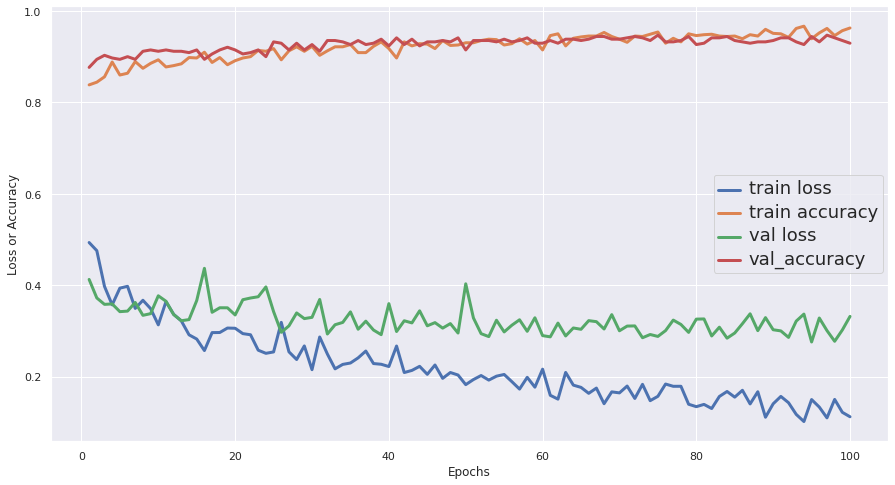

In [16]:
# eval the fine tuned model
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=32)
print(classification_report(testy.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=unique_class_names))

# plot the performance
epochs = range(1, 101)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(
    data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
    columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss',
             linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax,
             label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss',
             linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax,
             label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18');  # for legend text